In [2]:
import numpy as np
from sklearn import datasets
from sklearn.naive_bayes import GaussianNB
from sklearn import svm

In [3]:
# This line tells the notebook to show plots inside of the notebook
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sb

In [ ]:
import pandas as pd

iris_data = pd.read_csv('../../../iris-data.csv')
iris_data.head()

In [ ]:
iris_data = pd.read_csv('../../../iris-data.csv', na_values=['NA'])

In [ ]:
iris_data.describe()

In [ ]:
# We have to temporarily drop the rows with 'NA' values
# because the Seaborn plotting function does not know
# what to do with them
sb.pairplot(iris_data.dropna(), hue='class')

In [ ]:
iris_data.loc[iris_data['class'] == 'versicolor', 'class'] = 'Iris-versicolor'
iris_data.loc[iris_data['class'] == 'Iris-setossa', 'class'] = 'Iris-setosa'

iris_data['class'].unique()

In [ ]:
# This line drops any 'Iris-setosa' rows with a separal width less than 2.5 cm
iris_data = iris_data.loc[(iris_data['class'] != 'Iris-setosa') | (iris_data['sepal_width_cm'] >= 2.5)]
iris_data.loc[iris_data['class'] == 'Iris-setosa', 'sepal_width_cm'].hist()

In [ ]:
iris_data.loc[(iris_data['class'] == 'Iris-versicolor') &
              (iris_data['sepal_length_cm'] < 1.0),
              'sepal_length_cm'] *= 100.0

iris_data.loc[iris_data['class'] == 'Iris-versicolor', 'sepal_length_cm'].hist()

In [ ]:
average_petal_width = iris_data.loc[iris_data['class'] == 'Iris-setosa', 'petal_width_cm'].mean()

iris_data.loc[(iris_data['class'] == 'Iris-setosa') &
              (iris_data['petal_width_cm'].isnull()),
              'petal_width_cm'] = average_petal_width

iris_data.loc[(iris_data['class'] == 'Iris-setosa') &
              (iris_data['petal_width_cm'] == average_petal_width)]

In [ ]:
sb.pairplot(iris_data, hue='class')

In [ ]:
plt.figure(figsize=(10, 10))

for column_index, column in enumerate(iris_data.columns):
    if column == 'class':
        continue
    plt.subplot(2, 2, column_index + 1)
    sb.violinplot(x='class', y=column, data=iris_data)

In [ ]:
# We can extract the data in this format from pandas like this:
all_inputs = iris_data[['sepal_length_cm', 'sepal_width_cm',
                             'petal_length_cm', 'petal_width_cm']].values

# Similarly, we can extract the classes
all_classes = iris_data['class'].values

In [ ]:
from sklearn.model_selection import train_test_split

(training_inputs,
 testing_inputs,
 training_classes,
 testing_classes) = train_test_split(all_inputs, all_classes, train_size=0.75, test_size=0.25, random_state=1)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, make_scorer

# Create the classifier
decision_tree_classifier = DecisionTreeClassifier()

# Train the classifier on the training set
decision_tree_classifier.fit(training_inputs, training_classes)

# Validate the classifier on the testing set using classification accuracy
decision_tree_classifier.score(testing_inputs, testing_classes)

In [ ]:
model_f1_accuracies = []

for repetition in range(1000):
    (training_inputs,
     testing_inputs,
     training_classes,
     testing_classes) = train_test_split(all_inputs, all_classes, train_size=0.75, test_size=0.25)
    
    decision_tree_classifier = DecisionTreeClassifier(random_state=0)
    decision_tree_classifier.fit(training_inputs, training_classes)
    
    y_pred = decision_tree_classifier.predict(testing_inputs)
    classifier_f1_accuracy = f1_score(testing_classes, y_pred, average='micro')
    model_f1_accuracies.append(classifier_f1_accuracy)
    
sb.distplot(model_f1_accuracies)

In [ ]:
from sklearn.cross_validation import StratifiedKFold

def plot_cv(cv, n_samples):
    masks = []
    for train, test in cv:
        mask = np.zeros(n_samples, dtype=bool)
        mask[test] = 1
        masks.append(mask)
        
    plt.figure(figsize=(15, 15))
    plt.imshow(masks, interpolation='none')
    plt.ylabel('Fold')
    plt.xlabel('Row #')

plot_cv(StratifiedKFold(all_classes, n_folds=10), len(all_classes))

In [ ]:
from sklearn.cross_validation import cross_val_score

decision_tree_classifier = DecisionTreeClassifier(random_state=0)

# cross_val_score returns a list of the scores, which we can visualize
# to get a reasonable estimate of our classifier's performance
cross_validation = StratifiedKFold(all_classes, n_folds=10)

cv_scores_dt = cross_val_score(decision_tree_classifier, all_inputs, all_classes, cv=cross_validation)
sb.distplot(cv_scores_dt)
plt.title('Average score: {}'.format(np.mean(cv_scores_dt)))

In [ ]:
decision_tree_classifier = DecisionTreeClassifier(max_depth=1)

cv_scores = cross_val_score(decision_tree_classifier, all_inputs, all_classes, cv=10, scoring=make_scorer(f1_score, average='micro'))
sb.distplot(cv_scores, kde=False)
plt.title('Average score: {}'.format(np.mean(cv_scores)))

In [ ]:
from sklearn.model_selection import GridSearchCV

decision_tree_classifier = DecisionTreeClassifier(random_state=0)

parameter_grid = {'max_depth': [1, 2, 3, 4, 5],
                  'max_features': [1, 2, 3, 4]}

cross_validation = StratifiedKFold(all_classes, n_folds=10)

grid_search = GridSearchCV(decision_tree_classifier,
                           param_grid=parameter_grid,
                           cv=cross_validation)

grid_search.fit(all_inputs, all_classes)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

In [ ]:
grid_visualization = []

for grid_pair in grid_search.cv_results_:
    if "mean_test_score" == grid_pair:
        for score in grid_search.cv_results_[grid_pair]:
            grid_visualization.append(score)
    
grid_visualization = np.array(grid_visualization)

grid_visualization.shape = (5, 4)
sb.heatmap(grid_visualization, cmap='Blues')
plt.xticks(np.arange(4) + 0.5, grid_search.param_grid['max_features'])
plt.yticks(np.arange(5) + 0.5, grid_search.param_grid['max_depth'])
plt.xlabel('max_features')
plt.ylabel('max_depth')

In [ ]:
decision_tree_classifier = DecisionTreeClassifier(random_state=0)

parameter_grid = {'criterion': ['gini', 'entropy'],
                  'splitter': ['best', 'random'],
                  'max_depth': [1, 2, 3, 4, 5],
                  'max_features': [1, 2, 3, 4]}

cross_validation = StratifiedKFold(all_classes, n_folds=10, random_state=0)

grid_search = GridSearchCV(decision_tree_classifier,
                           param_grid=parameter_grid,
                           cv=cross_validation, scoring=make_scorer(f1_score, average='micro'))

grid_search.fit(all_inputs, all_classes)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

In [ ]:
decision_tree_classifier = grid_search.best_estimator_
decision_tree_classifier

In [ ]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight("balanced", np.array(iris_data['class'].unique()), all_classes)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

random_forest_classifier = RandomForestClassifier(random_state=0)

parameter_grid = {'n_estimators': [5, 10, 25, 50],
                  'criterion': ['gini', 'entropy'],
                  'max_features': [1, 2, 3, 4],
                  'warm_start': [True, False]}

cross_validation = StratifiedKFold(all_classes, n_folds=10, random_state=0)

grid_search = GridSearchCV(random_forest_classifier,
                           param_grid=parameter_grid,
                           cv=cross_validation, scoring=make_scorer(f1_score, average='micro'))

grid_search.fit(all_inputs, all_classes)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

grid_search.best_estimator_

In [ ]:
random_forest_classifier = grid_search.best_estimator_

Below is the cross-validation scores of the best random forest classifier on the entire dataset.

In [ ]:
cv_scores_dt = cross_val_score(decision_tree_classifier, all_inputs, all_classes, cv=10, scoring=make_scorer(f1_score, average='micro'))
cv_scores_rf = cross_val_score(random_forest_classifier, all_inputs, all_classes, cv=10, scoring=make_scorer(f1_score, average='micro'))

print("Decision tree:", np.mean(cv_scores_dt))
print("Random forest:", np.mean(cv_scores_rf))

sb.distplot(cv_scores_rf, label="random forest")
sb.distplot(cv_scores_dt, label="decision tree")
plt.legend()
plt.title('Average scores:')

In [ ]:
random_forest_classifier = grid_search.best_estimator_

rf_df = pd.DataFrame({'accuracy': cross_val_score(random_forest_classifier, all_inputs, all_classes, cv=10),
                       'classifier': ['Random Forest'] * 10})
dt_df = pd.DataFrame({'accuracy': cross_val_score(decision_tree_classifier, all_inputs, all_classes, cv=10),
                      'classifier': ['Decision Tree'] * 10})
both_df = rf_df.append(dt_df)

sb.boxplot(x='classifier', y='accuracy', data=both_df)
sb.stripplot(x='classifier', y='accuracy', data=both_df, jitter=True, color='red')

In [ ]:
random_forest_classifier.feature_importances_

In [ ]:
importances = random_forest_classifier.feature_importances_
std = np.std([tree.feature_importances_ for tree in random_forest_classifier.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(all_inputs.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(all_inputs.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(all_inputs.shape[1]), indices)
plt.xlim([-1, all_inputs.shape[1]])
plt.show()

In [ ]:
# We can jump directly to working with the clean data because we saved our cleaned data set
# iris_data = pd.read_csv('iris-data-clean.csv')

# Testing our data: Our analysis will stop here if any of these assertions are wrong

# We know that we should only have three classes
assert len(iris_data['class'].unique()) == 3

# We know that sepal lengths for 'Iris-versicolor' should never be below 2.5 cm
assert iris_data.loc[iris_data['class'] == 'Iris-versicolor', 'sepal_length_cm'].min() >= 2.5

# We know that our data set should have no missing measurements
assert len(iris_data.loc[(iris_data['sepal_length_cm'].isnull()) |
                               (iris_data['sepal_width_cm'].isnull()) |
                               (iris_data['petal_length_cm'].isnull()) |
                               (iris_data['petal_width_cm'].isnull())]) == 0

all_inputs = iris_data[['sepal_length_cm', 'sepal_width_cm',
                             'petal_length_cm', 'petal_width_cm']].values

all_classes = iris_data['class'].values

# This is the classifier that came out of Grid Search
random_forest_classifier = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                                max_depth=None, max_features=3, max_leaf_nodes=None,
                                min_samples_leaf=1, min_samples_split=2,
                                min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=1,
                                oob_score=False, random_state=0, warm_start=True)

# Naive bayes now
third = float(1 / 3)
nb_priors = np.array([third, third, third])
nb_classifier = GaussianNB(nb_priors)

# SVM
# svm_classifier = svm.SVC(C=200, cache_size=200, class_weight=None, coef0=0.0,
#   decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
#   max_iter=-1, probability=False, random_state=None, shrinking=True,
#   tol=0.001, verbose=False)
svm_classifier = svm.SVC(C=1.0, kernel='rbf', degree=3, gamma='auto', 
                         coef0=0.0, shrinking=True, probability=False, 
                         tol=0.001, cache_size=200, class_weight=None, 
                         verbose=False, max_iter=-1, decision_function_shape='ovr', random_state=None)

# All that's left to do now is plot the cross-validation scores
rf_classifier_scores = cross_val_score(random_forest_classifier, all_inputs, all_classes, cv=10)
nb_classifier_scores = cross_val_score(nb_classifier, all_inputs, all_classes, cv=10)
svm_classifier_scores = cross_val_score(svm_classifier, all_inputs, all_classes, cv=10)

sb.distplot(cv_scores_dt, label="decision tree")
sb.distplot(rf_classifier_scores, label="random forest")
sb.distplot(nb_classifier_scores, label="naive bayes")
sb.distplot(svm_classifier_scores, label="support vector machine")
plt.legend()

# ...and show some of the predictions from the classifier
(training_inputs,
 testing_inputs,
 training_classes,
 testing_classes) = train_test_split(all_inputs, all_classes, train_size=0.75, test_size=0.25)

# random_forest_classifier.fit(training_inputs, training_classes)

In [ ]:
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

# #############################################################################
# Data IO and generation

# Import some data to play with
iris = datasets.load_iris()
X = iris.data
y = iris.target

# Only works for binary classes, not multiclass problems (or rather you'll need to work around that). Not
# an issue for the dataset we are working with.
X, y = X[y != 2], y[y != 2]
n_samples, n_features = X.shape

# Add noisy features
random_state = np.random.RandomState(0)
X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

# #############################################################################
# Classification and ROC analysis

# Run classifier with cross-validation and plot ROC curves
# Must have probability=True in order to work as you need to predict proba
cv = StratifiedKFold(n_splits=5)
classifier = svm.SVC(kernel='linear', probability=True,
                     random_state=random_state)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
for train, test in cv.split(X, y):
    probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    print(roc_auc)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.6,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Luck', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

# std_tpr = np.std(tprs, axis=0)
# tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
# tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
# plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
#                  label=r'$\pm$ 1 std. dev.')

plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
print(auc([0, 0, 1], [0, 1, 1]))

In [ ]:
test_fpr = np.array([0, 0, 1])
test_tpr = np.array([0, 1, 1])

roc_auc = auc(test_fpr, test_tpr)

plt.plot(test_fpr, test_tpr, lw=2, alpha=0.8,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Luck', alpha=.8)
plt.xlim([-0.03, 1.03])
plt.ylim([-0.03, 1.03])
plt.legend()

In [ ]:
def plot_decision_function(X, y, clf, ax):
    plot_step = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.4)
    ax.scatter(X[:, 0], X[:, 1], alpha=0.8, c=y, edgecolor='k')

In [7]:
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle
# import scikitplot as skplt
from sklearn.model_selection import StratifiedKFold
from sklearn import svm, datasets, tree
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression

# Import some data to play with
iris = datasets.load_iris()
X = iris.data
y = iris.target
X, y = X[y != 2], y[y != 2]
n_samples, n_features = X.shape

# Add noisy features
random_state = np.random.RandomState(0)
X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

# #############################################################################
# Classification and ROC analysis

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold()
classifier = svm.SVC(kernel='poly', probability=True,
                     random_state=random_state)
# classifier = tree.DecisionTreeClassifier()

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 1
for train, test in cv.split(X, y):
    probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
    
    y_true = y[test] # ground truth labels
    y_probas = probas_[:, 1] # predicted probabilities generated by sklearn classifier
#     skplt.metrics.plot_roc_curve(y_true, y_probas)
#     plt.show()

    # Compute ROC curve and area the curve
#     fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
#     tprs.append(interp(mean_fpr, fpr, tpr))
#     tprs[-1][0] = 0.0
#     roc_auc = auc(fpr, tpr)
#     aucs.append(roc_auc)
#     plt.plot(fpr, tpr, lw=1, alpha=0.3,
#              label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

#     i += 1
# plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
#          label='Luck', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

/Users/soutar/miniconda3/envs/cs4098/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/soutar/miniconda3/envs/cs4098/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


TypeError: 'numpy.float64' object does not support item assignment

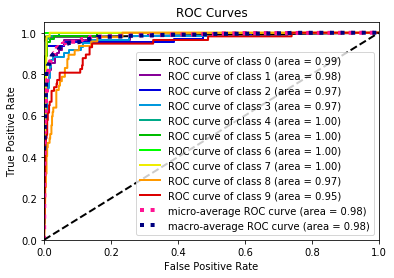

In [2]:
# The usual train-test split mumbo-jumbo
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

X, y = load_digits(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
nb = GaussianNB()
nb.fit(X_train, y_train)
predicted_probas = nb.predict_proba(X_test)

# The magic happens here
import matplotlib.pyplot as plt
import scikitplot as skplt
skplt.metrics.plot_roc_curve(y_test, predicted_probas)
plt.show()